## Markov Chain scaling

- Check paths using bfs from start to target.
- Remove nodes not invloved in these paths.
- Idenitfy by strongly connected components and check acycic, monocyclic or multicyclic.

#### Polynomical scaling
#### Exponential scaling

In [2]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
from scipy.sparse.linalg import eigs


def markov_chain_scaling(P, start, target):
    """
    Computes the asymptotic scaling of the r^th most probable path from start
    to target in the Markov chain with transition probabilities P.
    """

    # Ensure P is in sparse form for large computations
    N = P.shape[0]
    P1 = nx.DiGraph(P)

    # Convert target to a list if it's a single integer
    if isinstance(target, int):
        target = [target]

    # Identify reachable states from start and states that can reach target
    reach_from_start = sorted(list(nx.bfs_tree(P1, start)))

    reach_to_target = set()
    for t in target:
        reach_to_target.update(nx.bfs_tree(P1.reverse(), t))

    reach_to_target = sorted(reach_to_target)
    good_verts = np.intersect1d(reach_from_start, reach_to_target)
    bad_verts = np.setdiff1d(np.arange(N), good_verts) # those who don't come in start-target path as we don't need them

    # Modify P2 to remove bad vertices
    P2 = P.copy()
    P2[bad_verts, :] = 0
    P2[:, bad_verts] = 0

    # Get strongly connected components and their types
    n_comps, comp_nums = sp.csgraph.connected_components(P2, directed=True, connection='strong')

    comp_verts = [np.where(comp_nums == c)[0] for c in range(n_comps)]
    comp_types = np.zeros(n_comps, dtype=int)

    for c in range(n_comps):
        subgraph = P2[comp_verts[c], :][:, comp_verts[c]]
        n_links = np.sum(subgraph > 0)
        if n_links == len(comp_verts[c]):
            comp_types[c] = 1 #monocyclic
        elif n_links > len(comp_verts[c]):
            comp_types[c] = 2 #multicyclic

    # Determine the graph type
    graph_type = np.max(comp_types)

    # Finite number of paths
    if graph_type == 0:
        return [0]

    # Polynomial growth in number of paths
    if graph_type == 1:
        slope, k = mcs_polynomial(P2, start, target, comp_nums, comp_types, comp_verts)
        return [1, slope, k]

    # Exponential growth in number of paths
    if graph_type == 2:
        slope = mcs_exponential(P2, comp_types, comp_verts)
        return [2, slope]


def mcs_polynomial(P2, start, target, comp_nums, comp_types, comp_verts):
    """
    Compute the slope and k of the log10 path probability P(r) versus the kth root of rank r.
    """

    # Compute the number of links between different components
    n_comp = len(comp_types)
    clinks = sp.lil_matrix((n_comp, n_comp))
    I, J = P2.nonzero()

    for i in range(len(I)):
        ci = comp_nums[I[i]]
        cj = comp_nums[J[i]]
        if ci != cj:
            clinks[ci, cj] += 1

    # Compute the negative log probability of going around each cycle component
    comp_nlp = np.full(n_comp, np.nan)
    for c in range(n_comp):
        if comp_types[c] == 1:
            comp_nlp[c] = 0
            for v in comp_verts[c]:
                j = np.nonzero(P2[v, comp_verts[c]])[0]
                comp_nlp[c] -= np.log(P2[v, comp_verts[c][j]])

    # Topological order of components
    top_order = list(nx.topological_sort(nx.DiGraph(clinks)))

    # Dynamic programming to compute slope and order K
    A0 = np.full(n_comp, np.nan) #transition probab
    A1 = np.full(n_comp, np.nan) #maximum number of cycles that may be encountered along any path in G from a vertex in 
    # f−1(ui) to the END
    for t in target:
        A0[comp_nums[t]] = 1
        A1[comp_nums[t]] = 0

    for c in reversed(top_order):
        if np.isnan(A0[c]):
            # Use .nonzero() or .toarray() to avoid sparse matrix comparison issues
            next_comps = clinks[c, :].nonzero()[1]
            next_comps = next_comps[~np.isnan(A0[next_comps])]
            if len(next_comps) > 0:
                max_a1 = np.max(A1[next_comps])
                next_comps = next_comps[A1[next_comps] == max_a1]
                if comp_types[c] == 0:
                    A1[c] = max_a1
                    A0[c] = np.sum(clinks[c, next_comps].toarray() * A0[next_comps])
                elif comp_types[c] == 1:
                    A1[c] = max_a1 + 1
                    A0[c] = np.sum(clinks[c, next_comps].toarray() * A0[next_comps]) / (comp_nlp[c] * A1[c])

    start_comp = comp_nums[start]
    K = A1[start_comp]
    slope = -1 / (A0[start_comp] ** (1 / A1[start_comp]))

    return slope, K



def mcs_exponential(P2, comp_types, comp_verts):
    """
    Find the slope of log10 path probability (P(r)) versus log10 rank r.
    """
    n_comp = len(comp_types)
    comp_lambdas = np.full(n_comp, np.inf)
    for c in range(n_comp):
        if comp_types[c] == 2:
            comp_lambdas[c] = mcs_exponential_lambda(P2[comp_verts[c], :][:, comp_verts[c]])

    lambda_min = np.min(comp_lambdas)
    slope = 1 / lambda_min
    return slope


def mcs_exponential_lambda(Ptemp):
    """
    Find the value of Lambda such that the matrix Ptemp.^(-Lambda) has a largest eigenvalue equal to 1.
    """

    I = Ptemp.nonzero()
    N = Ptemp.shape[0]

    # Find upper limit on Lambda
    lambda_hi = 1
    M = sp.lil_matrix((N, N))
    M[I] = Ptemp[I] ** (-lambda_hi)
    E = eigs(M, k=1, return_eigenvectors=False)

    while abs(np.real(E[0])) <= 1:
        lambda_hi *= 2
        M[I] = Ptemp[I] ** (-lambda_hi)
        E = eigs(M, k=1, return_eigenvectors=False)

    # Find lower limit on Lambda
    lambda_lo = -1
    M[I] = Ptemp[I] ** (-lambda_lo)
    E = eigs(M, k=1, return_eigenvectors=False)

    while abs(np.real(E[0])) >= 1:
        lambda_lo *= 2
        M[I] = Ptemp[I] ** (-lambda_lo)
        E = eigs(M, k=1, return_eigenvectors=False)

    # Use binary search to narrow down Lambda
    lambda_tol = 1e-10
    while abs(lambda_hi - lambda_lo) > lambda_tol:
        lambda_mid = (lambda_hi + lambda_lo) / 2
        M[I] = Ptemp[I] ** (-lambda_mid)
        E = eigs(M, k=1, return_eigenvectors=False)

        if abs(np.real(E[0])) >= 1:
            lambda_hi = lambda_mid
        else:
            lambda_lo = lambda_mid

    return (lambda_hi + lambda_lo) / 2


## Path probs helper

In [3]:
import numpy as np

def path_log_probs_above_helper(log_probs, log_prob_cutoff, curr_state, log_prob_so_far, target_states, end_states, path_so_far):
    path_log_prob_list = []

    # If probability too low, return an empty list
    if log_prob_so_far < log_prob_cutoff:
        return path_log_prob_list

    # If at a target state, add its probability to the path probability list
    if curr_state in target_states:
        path_log_prob_list.append(log_prob_so_far)

    # If we're at an end state, return the list
    if curr_state in end_states:
        return path_log_prob_list

    # Otherwise, go on to consider all extensions (recursive)
    next_states = np.where(log_probs[curr_state, :] > -np.inf)[0]  # equivalent of MATLAB's `find`
    for next_state in next_states:
        temp_list = path_log_probs_above_helper(log_probs, log_prob_cutoff, next_state,log_prob_so_far + log_probs[curr_state, next_state],target_states, end_states, path_so_far + [next_state])
        path_log_prob_list.extend(temp_list) 

    return path_log_prob_list


## Path probs

In [4]:
import numpy as np

def path_log_probs_above(P, prob, start_state, target_states, end_states=None):
    """
    P is a square probability transition matrix.
    prob is a probability cutoff (not in log scale).
    start_state is the origin of all paths.
    target_states is a list of all possible path endpoints.
    end_states is a list of states where we actually end a path. (Optional, defaults to target_states.)
    
    Returns a list of path log probabilities for all paths starting at start_state,
    having probability at least 'prob', and ending in target_states without passing through end_states.
    """

    # If end_states is not provided, default it to target_states
    if end_states is None:
        end_states = target_states

    # Compute log of the transition probabilities
    log_probs = np.log(P)

    # Convert the probability cutoff to log scale
    log_prob_cutoff = np.log(prob)

    # Call the helper function to compute the list of path log probabilities
    path_log_prob_list = path_log_probs_above_helper(
        log_probs, log_prob_cutoff, start_state, 0, target_states, end_states, [start_state]
    )

    return path_log_prob_list


## Path probs Nlargest

In [5]:
import numpy as np

def path_log_probs_n_largest(P, N, start_state, target_states, end_states=None):
    """
    Computes the log probabilities of the paths with the N highest probabilities,
    starting from start_state, reaching target_states, and not passing through end_states.
    """

    # If end_states is not provided, default it to target_states
    if end_states is None:
        end_states = target_states

    print('PathLogProbs_NLargest: Finding probability cutoff for depth-first search')
    print('Prob     NPaths')

    # Initial probability cutoff
    curr_prob_cutoff = 0.5
    temp_log_prob_list = path_log_probs_above(P, curr_prob_cutoff, start_state, target_states, end_states)
    print(f'{curr_prob_cutoff:.6f}     {len(temp_log_prob_list)}')

    # Keep reducing the cutoff until we have at least N paths
    while len(temp_log_prob_list) < N:
        curr_prob_cutoff *= 0.5
        temp_log_prob_list = path_log_probs_above(P, curr_prob_cutoff, start_state, target_states, end_states)
        print(f'{curr_prob_cutoff:.6f}     {len(temp_log_prob_list)}')

    # Sort the log probabilities in descending order and take the top N
    temp_log_prob_list = sorted(temp_log_prob_list, reverse=True)
    path_log_prob_list = temp_log_prob_list[:N]

    return path_log_prob_list


## Mat 1

In [13]:
import matplotlib.pyplot as plt
# Exponential-scaling chain (Red Walk)
Mred = {
    'NStates': 6,
    'P': np.array([[0, 1, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0, 0],
                   [0, 0.55, 0, 0.45, 0, 0],
                   [0, 0, 0, 0, 1, 0],
                   [0, 0, 0.6, 0, 0, 0.4],
                   [0, 0, 0, 0, 0, 0]]),
    'Start': 0,
    'Target': 5
}

# Polynomial-scaling chain (Blue Walk)
Mblue = {
    'NStates': 6,
    'P': np.array([[0, 1, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0, 0],
                   [0, 0.55, 0, 0.45, 0, 0],
                   [0, 0, 0, 0, 1, 0],
                   [0, 0, 0, 0.6, 0, 0.4],
                   [0, 0, 0, 0, 0, 0]]),
    'Start': 0,
    'Target': 5
}

# Compute predicted scaling
print("Red walk scaling:")
RedScaling = markov_chain_scaling(Mred['P'], Mred['Start'], Mred['Target'])
print(RedScaling)

print("Blue walk scaling:")
BlueScaling = markov_chain_scaling(Mblue['P'], Mblue['Start'], Mblue['Target'])
print(BlueScaling)

# Make plots based on exact probabilities of the most-probable paths
NPaths = 100

# Compute log probabilities for red and blue chains
PLPred = sorted(path_log_probs_n_largest(Mred['P'], NPaths, Mred['Start'], [Mred['Target']], [Mred['Target']]), reverse=True)
PLPblue = sorted(path_log_probs_n_largest(Mblue['P'], NPaths, Mblue['Start'], [Mblue['Target']], [Mblue['Target']]), reverse=True)

# Convert log probabilities to probabilities
PPred = np.exp(PLPred)
PPblue = np.exp(PLPblue)

# Eliminate duplicates (optional, skipped)
# You can add logic here if you want to remove duplicates like in the original MATLAB code.
'''
# Plot on log-log scale
plt.figure(1)
plt.clf()
Ired = np.arange(1, len(PPred) + 1)
Iblue = np.arange(1, len(PPblue) + 1)

plt.plot(Iblue, PPblue, 'bo', label='Blue walk')
plt.plot(Ired, PPred, 'rd', label='Red walk')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Plot on log-sqrt scale
plt.figure(2)
plt.clf()

plt.plot(np.sqrt(Iblue), PPblue, 'bo', label='Blue walk')
plt.plot(np.sqrt(Ired), PPred, 'rd', label='Red walk')

# Axis formatting
Top = np.sqrt(max(max(Ired), max(Iblue)))
plt.xlim(0.99, Top)
plt.xticks(np.arange(1, int(np.ceil(Top)) + 1), labels=[f'{int(i**2)}' for i in range(1, int(np.ceil(Top)) + 1)])

plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
'''


Red walk scaling:
[2, -1.306715671701873]
Blue walk scaling:
[1, -0.7815247389831992, 2.0]
PathLogProbs_NLargest: Finding probability cutoff for depth-first search
Prob     NPaths
0.500000     0
0.250000     0
0.125000     1
0.062500     2
0.031250     4
0.015625     8
0.007812     17
0.003906     32
0.001953     50
0.000977     87
0.000488     143
PathLogProbs_NLargest: Finding probability cutoff for depth-first search
Prob     NPaths
0.500000     0
0.250000     0
0.125000     1
0.062500     4
0.031250     9
0.015625     15
0.007812     22
0.003906     31
0.001953     42
0.000977     55
0.000488     69
0.000244     84
0.000122     101


/tmp/ipykernel_443/1097938030.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  comp_nlp[c] -= np.log(P2[v, comp_verts[c][j]])
/tmp/ipykernel_443/3835127089.py:20: RuntimeWarning: divide by zero encountered in log
  log_probs = np.log(P)


'\n# Plot on log-log scale\nplt.figure(1)\nplt.clf()\nIred = np.arange(1, len(PPred) + 1)\nIblue = np.arange(1, len(PPblue) + 1)\n\nplt.plot(Iblue, PPblue, \'bo\', label=\'Blue walk\')\nplt.plot(Ired, PPred, \'rd\', label=\'Red walk\')\n\nplt.xscale(\'log\')\nplt.yscale(\'log\')\nplt.xlabel(\'Path rank, r\')\nplt.ylabel(\'Path probability, $P_r$\')\nplt.legend()\nplt.grid(True, which="both", ls="--")\nplt.show()\n\n# Plot on log-sqrt scale\nplt.figure(2)\nplt.clf()\n\nplt.plot(np.sqrt(Iblue), PPblue, \'bo\', label=\'Blue walk\')\nplt.plot(np.sqrt(Ired), PPred, \'rd\', label=\'Red walk\')\n\n# Axis formatting\nTop = np.sqrt(max(max(Ired), max(Iblue)))\nplt.xlim(0.99, Top)\nplt.xticks(np.arange(1, int(np.ceil(Top)) + 1), labels=[f\'{int(i**2)}\' for i in range(1, int(np.ceil(Top)) + 1)])\n\nplt.yscale(\'log\')\nplt.xlabel(\'Path rank, r\')\nplt.ylabel(\'Path probability, $P_r$\')\nplt.legend()\nplt.grid(True, which="both", ls="--")\nplt.show()\n'

## Red walk (log-log)

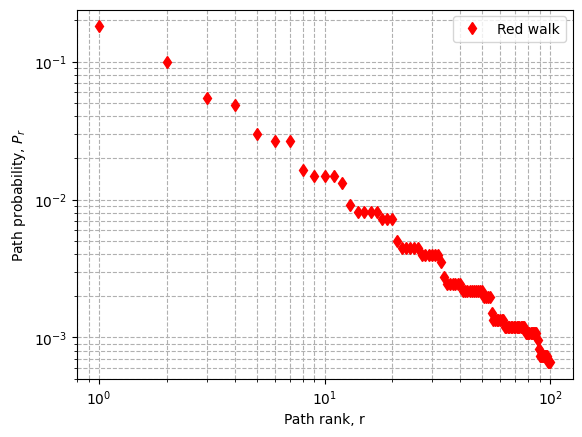

In [12]:
# Plot Red walk on log-log scale
plt.figure(1)
plt.clf()
Ired = np.arange(1, len(PPred) + 1)

plt.plot(Ired, PPred, 'rd', label='Red walk')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


##  Red Walk Plot (log-sqrt scale)



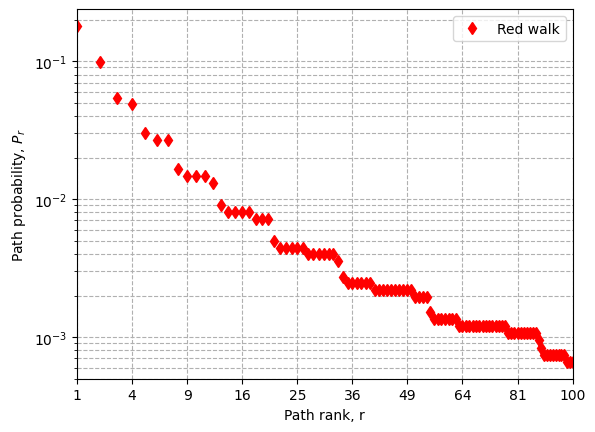

In [8]:
# Plot Red walk on log-sqrt scale
plt.figure(2)
plt.clf()

plt.plot(np.sqrt(Ired), PPred, 'rd', label='Red walk')

# Axis formatting
Top = np.sqrt(max(Ired))
plt.xlim(0.99, Top)
plt.xticks(np.arange(1, int(np.ceil(Top)) + 1), labels=[f'{int(i**2)}' for i in range(1, int(np.ceil(Top)) + 1)])

plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Blue Walk Plot (log-log scale)



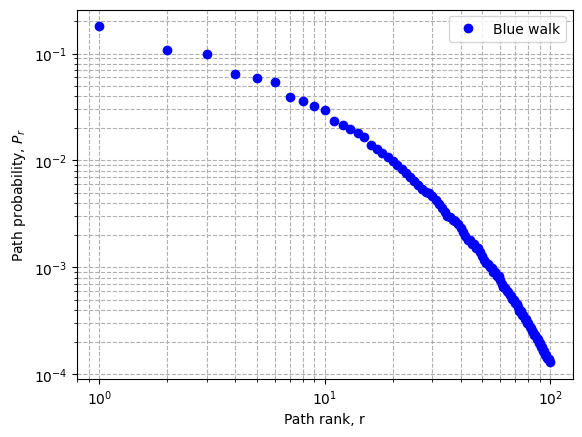

In [11]:
# Plot Blue walk on log-log scale
plt.figure(3)
plt.clf()
Iblue = np.arange(1, len(PPblue) + 1)

plt.plot(Iblue, PPblue, 'bo', label='Blue walk')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Blue Walk Plot (log-sqrt scale)



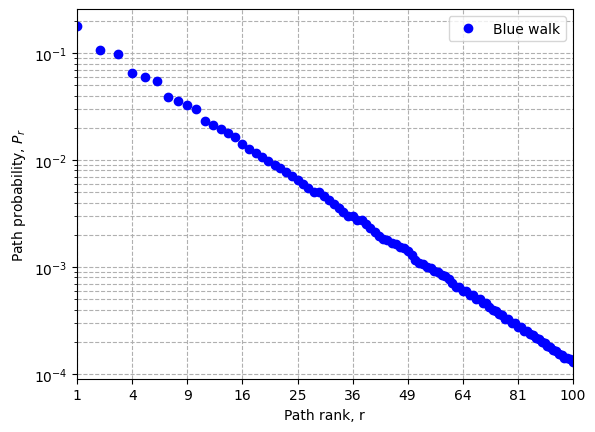

In [10]:
# Plot Blue walk on log-sqrt scale
plt.figure(4)
plt.clf()

plt.plot(np.sqrt(Iblue), PPblue, 'bo', label='Blue walk')

# Axis formatting
Top = np.sqrt(max(Iblue))
plt.xlim(0.99, Top)
plt.xticks(np.arange(1, int(np.ceil(Top)) + 1), labels=[f'{int(i**2)}' for i in range(1, int(np.ceil(Top)) + 1)])

plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Other Analysis

Blue walk exhibits polynomial growth with slope -0.7815247389831992 and k 2.0
Red walk exhibits exponential growth with slope -1.306715671701873


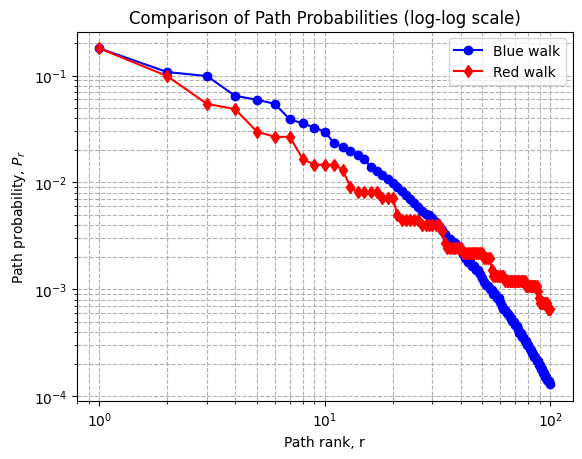

Mean path probability for Blue walk: 0.009963586747920684
Standard deviation of path probabilities for Blue walk: 0.02503060568597315
Mean path probability for Red walk: 0.007531678498665234
Standard deviation of path probabilities for Red walk: 0.02148607063362801


In [14]:
# Further analysis of the scaling behavior

# Analyze the scaling behavior of the Blue walk
if BlueScaling[0] == 1:
    print(f"Blue walk exhibits polynomial growth with slope {BlueScaling[1]} and k {BlueScaling[2]}")
elif BlueScaling[0] == 2:
    print(f"Blue walk exhibits exponential growth with slope {BlueScaling[1]}")
else:
    print("Blue walk exhibits finite number of paths")

# Analyze the scaling behavior of the Red walk
if RedScaling[0] == 1:
    print(f"Red walk exhibits polynomial growth with slope {RedScaling[1]}")
elif RedScaling[0] == 2:
    print(f"Red walk exhibits exponential growth with slope {RedScaling[1]}")
else:
    print("Red walk exhibits finite number of paths")

# Compare the path probabilities
plt.figure(5)
plt.clf()
plt.plot(Iblue, PPblue, 'bo-', label='Blue walk')
plt.plot(Ired, PPred, 'rd-', label='Red walk')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.title('Comparison of Path Probabilities (log-log scale)')
plt.show()

# Additional statistical analysis
mean_blue = np.mean(PPblue)
mean_red = np.mean(PPred)
std_blue = np.std(PPblue)
std_red = np.std(PPred)

print(f"Mean path probability for Blue walk: {mean_blue}")
print(f"Standard deviation of path probabilities for Blue walk: {std_blue}")
print(f"Mean path probability for Red walk: {mean_red}")
print(f"Standard deviation of path probabilities for Red walk: {std_red}")

## Arbitrary walk

In [16]:
# taking any arbitary P matrix and calculating walk type
np.random.seed(42)  # For reproducibility
Prd = np.random.rand(8, 8)
Prd = Prd / Prd.sum(axis=1, keepdims=True)  # Normalize rows to sum to 1
Marb = {
    'NStates': 8,
    'P': Prd,
    'Start': 0,
    'Target': 6
}

In [18]:
# Compute predicted scaling
print("Arb walk scaling:")
ArbScaling = markov_chain_scaling(Marb['P'], Marb['Start'], Marb['Target'])
print(ArbScaling)

# Make plots based on exact probabilities of the most-probable paths
NPaths = 100

# Compute log probabilities for arb chain
PLParb = sorted(path_log_probs_n_largest(Marb['P'], NPaths, Marb['Start'], [Marb['Target']], [Marb['Target']]), reverse=True)

# Convert log probabilities to probabilities
PParb = np.exp(PLParb)


Arb walk scaling:
[2, -0.9999999999854481]
PathLogProbs_NLargest: Finding probability cutoff for depth-first search
Prob     NPaths
0.500000     0
0.250000     0
0.125000     0
0.062500     1
0.031250     1
0.015625     3
0.007812     8
0.003906     17
0.001953     28
0.000977     61
0.000488     112


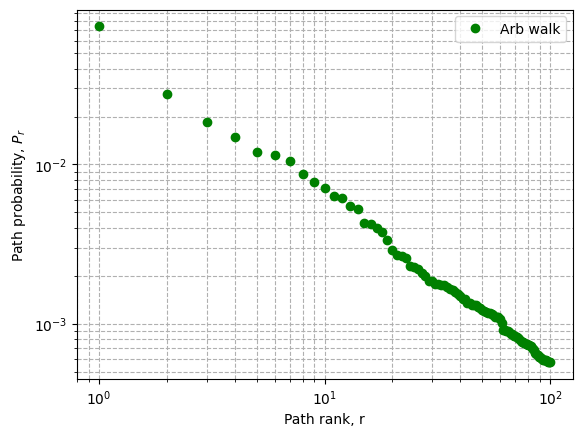

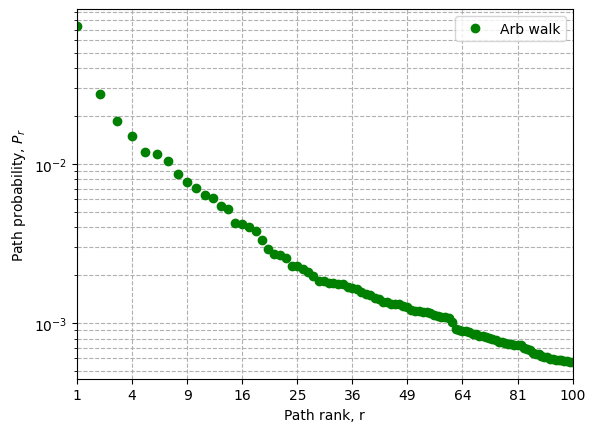

In [19]:
# plot arbwalk in log-log and log-sqrt scale
# Plot Arb walk on log-log scale
plt.figure(5)
plt.clf()
Iarb = np.arange(1, len(PParb) + 1)

plt.plot(Iarb, PParb, 'go', label='Arb walk')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Plot Arb walk on log-sqrt scale
plt.figure(6)
plt.clf()

plt.plot(np.sqrt(Iarb), PParb, 'go', label='Arb walk')

# Axis formatting
Top = np.sqrt(max(Iarb))
plt.xlim(0.99, Top)
plt.xticks(np.arange(1, int(np.ceil(Top)) + 1), labels=[f'{int(i**2)}' for i in range(1, int(np.ceil(Top)) + 1)])

plt.yscale('log')
plt.xlabel('Path rank, r')
plt.ylabel('Path probability, $P_r$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
